# poor/rich neighborhoods and social ties
(sandorjuhasz & kovacsa shared notebook)

In [1]:
#import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import matplotlib.gridspec as gridspec

import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString

import json
import time
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

In [2]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

In [3]:
# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

Bootstrapping via https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d

In [4]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

## plot 1 --- density of ties around home poor/rich

In [7]:
# construct a dataframe -rich- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000',
    'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']

# annotations
annotations = ['0.5','1', '1.5','2','2.5','3','3.5','4', '4.5', '5', '5.5','6','6.5', '7','7.5','8','8.5','9','9.5', '10']

# type plot
type = ["rich"] * 20

# multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16.. -- 1,3,5,7...)
x = np.concatenate([np.linspace(1,39,20),np.linspace(1,39,20)])

# table and columns to use
temp = degree_rich.loc[:, degree_rich.columns.isin(col_filter)]

# loop for variables
for idx, c in enumerate(list(temp.columns)):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 10000) # bootstrap
    area_mean = (bootstrap_mean * 1/x[idx]) * 1/(0.25*np.pi)   # area of the circle defined in the baseline 0.5*0.5*pi area
    means.append(np.mean(area_mean))
    lower.append(np.percentile(area_mean, 2.5))
    upper.append(np.percentile(area_mean, 97.5))
    error_lower.append((np.mean(area_mean) - np.percentile(area_mean, 2.5)))
    error_upper.append((np.percentile(area_mean, 97.5) - np.mean(area_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [9]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000',
    'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']

# annotations
annotations = ['0.5','1', '1.5','2','2.5','3','3.5','4', '4.5', '5', '5.5','6','6.5', '7','7.5','8','8.5','9','9.5', '10']

# type plot
type = ["poor"] * 20

# multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16.. -- 1,3,5,7...)
x = np.concatenate([np.linspace(1,39,20),np.linspace(1,39,20)])

# table and columns to use
temp = degree_poor.loc[:, degree_poor.columns.isin(col_filter)]

# loop for variables
for idx, c in enumerate(list(temp.columns)):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 10000) # bootstrap
    area_mean = (bootstrap_mean * 1/x[idx]) * 1/(0.25*np.pi)   # area of the circle defined in the baseline 0.5*0.5*pi area
    means.append(np.mean(area_mean))
    lower.append(np.percentile(area_mean, 2.5))
    upper.append(np.percentile(area_mean, 97.5))
    error_lower.append((np.mean(area_mean) - np.percentile(area_mean, 2.5)))
    error_upper.append((np.percentile(area_mean, 97.5) - np.mean(area_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [10]:
# combine
plotdata = pd.concat([result_rich, result_poor])

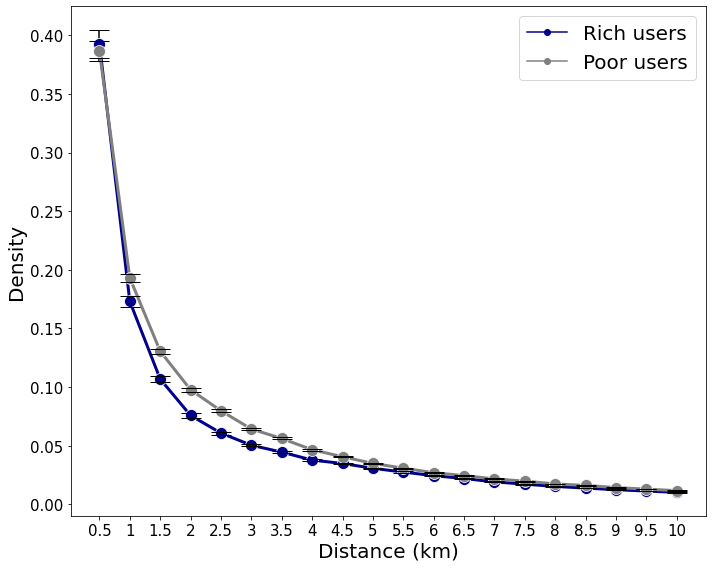

In [28]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(9, 5))

# colors of lines
colorsList = ["darkblue", "grey"]

# lineplots created
sns.lineplot(data = plotdata, x = 'distance', y = 'mean', hue = 'type', style = 'type', palette = colorsList, ax = ax, markers=["o", "o"], markersize = 12, dashes = False, linewidth = 3)

# add errorbars
ax.errorbar(data = plotdata, x = 'distance', y = 'mean', yerr= [plotdata['error_lower'], plotdata['error_upper']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=['Poor users', 'Rich users'], fontsize = 20, edgecolor = 'black')
ax.legend(handles=handles[0:], labels=['Rich users', 'Poor users'], fontsize = 20)
ax.set(xlabel='Distance (km)', ylabel='Density')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.tick_params(axis = 'x',rotation = 45)

plt.tight_layout()

## cumulative share of friends around home by income level

In [4]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

In [5]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [6]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['dcum500_share','dcum1000_share', 'dcum1500_share','dcum2000_share', 'dcum2500_share','dcum3000_share', 'dcum3500_share','dcum4000_share',  'dcum4500_share', 'dcum5000_share',
    'dcum5500_share','dcum6000_share', 'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share', 'dcum8500_share', 'dcum9000_share', 'dcum9500_share', 'dcum10000_share']

# annotations
annotations = np.linspace(0.5,10,20)

# type plot
type = ["poor"] * 20

# table and columns to use
temp = degree_poor.loc[:, degree_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [7]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['dcum500_share','dcum1000_share', 'dcum1500_share','dcum2000_share', 'dcum2500_share','dcum3000_share', 'dcum3500_share','dcum4000_share',  'dcum4500_share', 'dcum5000_share',
    'dcum5500_share','dcum6000_share', 'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share', 'dcum8500_share', 'dcum9000_share', 'dcum9500_share', 'dcum10000_share']

# annotations
annotations = np.linspace(0.5,10,20)

# type plot
type = ["rich"] * 20

# table and columns to use
temp = degree_rich.loc[:, degree_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [8]:
# combine
plotdata = pd.concat([result_rich, result_poor])

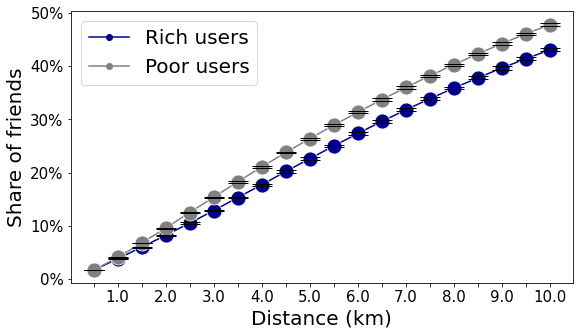

In [35]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(9,5))

# colors of lines
colorsList = ["darkblue", "grey"]

# lineplot created
ax = sns.lineplot(data = plotdata, x = 'distance', y = 'mean', hue = 'type', style = 'type', palette = colorsList, dashes=False, ax = ax, markers=["o", "o"], markersize = 15)

ax.errorbar(data = plotdata, x = 'distance', y = 'mean', yerr= [plotdata['error_lower'], plotdata['error_upper']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Rich users', 'Poor users'], fontsize = 20)
ax.set(xlabel='Distance (km)', ylabel='Share of friends')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
# ax.set_title('Share of friends around home', size = 30)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

## avg share 1/5/10 plots

In [20]:
# run the above part until plotdata

# means
poor_means = [result_poor["mean"][1], result_poor['mean'][9], result_poor['mean'][19]]
rich_means = [result_rich["mean"][1], result_rich['mean'][9], result_rich['mean'][19]]

# errors
poor_error_lower = [result_poor['error_lower'][1], result_poor['error_lower'][9], result_poor['error_lower'][19]]
poor_error_upper = [result_poor['error_upper'][1], result_poor['error_upper'][9], result_poor['error_upper'][19]]
rich_error_lower = [result_rich['error_lower'][1], result_rich['error_lower'][9], result_rich['error_lower'][19]]
rich_error_upper = [result_rich['error_upper'][1], result_rich['error_upper'][9], result_rich['error_upper'][19]]

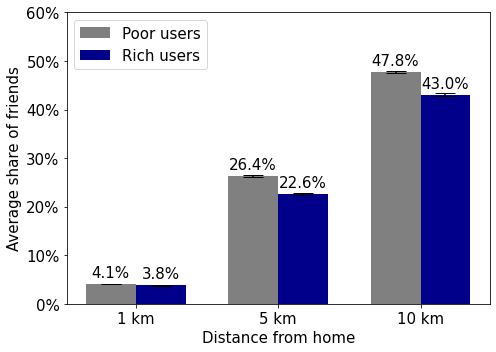

In [34]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

titles = ['1 km', '5 km', '10 km']
                                                                                                                    
# color of bars
colorsList = ["grey", "darkblue"]

# bars
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, poor_means, color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [poor_error_lower, poor_error_upper], capsize = 10)
rects2 = ax.bar(X + bar_width, rich_means, color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [rich_error_lower, rich_error_upper], capsize = 10) 

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 15, loc="upper left") # edgecolor = 'black'
ax.set(ylabel='Average share of friends')
ax.set(xlabel='Distance from home')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.6])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

## change in share of friends

In [36]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

Index(['user_id', 'cbsacode', 'short_name', 'poor', 'lat_home', 'lon_home',
       'degree', 'd500', 'd1000', 'd1500', 'd2000', 'd2500', 'd3000', 'd3500',
       'd4000', 'd4500', 'd5000', 'd5500', 'd6000', 'd6500', 'd7000', 'd7500',
       'd8000', 'd8500', 'd9000', 'd9500', 'd10000', 'dcum500', 'dcum1000',
       'dcum1500', 'dcum2000', 'dcum2500', 'dcum3000', 'dcum3500', 'dcum4000',
       'dcum4500', 'dcum5000', 'dcum5500', 'dcum6000', 'dcum6500', 'dcum7000',
       'dcum7500', 'dcum8000', 'dcum8500', 'dcum9000', 'dcum9500', 'dcum10000',
       'dcum500_share', 'dcum1000_share', 'dcum1500_share', 'dcum2000_share',
       'dcum2500_share', 'dcum3000_share', 'dcum3500_share', 'dcum4000_share',
       'dcum4500_share', 'dcum5000_share', 'dcum5500_share', 'dcum6000_share',
       'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share',
       'dcum8500_share', 'dcum9000_share', 'dcum9500_share',
       'dcum10000_share'],
      dtype='object')

In [41]:
# add new columns
col_list = ["d500", "d1000", "d1500", "d2000", "d2500", "d3000", "d3500", "d4000", "d4500", "d5000", "d5500", "d6000", "d6500", "d7000", "d7500", "d8000", "d8500", "d9000", "d9500", "d10000"]

for c in list(col_list):
    degree_tab[str(c) + "_share"] = degree_tab[str(c)] / degree_tab["degree"]

In [42]:
degree_tab

,user_id,cbsacode,short_name,poor,lat_home,lon_home,degree,d500,d1000,d1500,...,d5500_share,d6000_share,d6500_share,d7000_share,d7500_share,d8000_share,d8500_share,d9000_share,d9500_share,d10000_share
0,21,41860.0,San Francisco,1.0,37.780,-122.410,49,1.0,2.0,1.0,...,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000
1,47,35620.0,New York,0.0,40.717,-73.956,59,0.0,6.0,1.0,...,0.084746,0.084746,0.118644,0.067797,0.033898,0.016949,0.033898,0.016949,0.016949,0.016949
2,293,41860.0,San Francisco,1.0,37.762,-122.418,10,3.0,1.0,1.0,...,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,294,42660.0,Seattle,0.0,47.653,-122.356,11,0.0,1.0,0.0,...,0.090909,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.181818,0.000000,0.000000
4,364,14460.0,Boston,0.0,42.369,-71.154,29,0.0,0.0,0.0,...,0.068966,0.034483,0.103448,0.068966,0.068966,0.000000,0.034483,0.034483,0.034483,0.068966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86237,994290314,19740.0,Denver,1.0,39.673,-104.782,10,0.0,2.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
86238,994365709,35620.0,New York,1.0,40.785,-72.949,24,0.0,2.0,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000
86239,998305572,15380.0,Buffalo,1.0,42.913,-78.798,23,0.0,0.0,5.0,...,0.173913,0.043478,0.086957,0.043478,0.086957,0.000000,0.000000,0.043478,0.130435,0.043478
86240,1000525465,13820.0,Birmingham,0.0,33.623,-86.662,18,0.0,0.0,0.0,...,0.222222,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# loop -- degree share at distance
for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("d"+str(d))]
    
    degree_tab = pd.merge(degree_tab, temp, on="user_id", how="left")

# replace NA with 0
degree_tab = degree_tab.fillna(0)

In [ ]:
# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

In [199]:
# 
d_table_share = pd.concat([d_table.iloc[:,0], d_table.iloc[:,42:82]], axis = 1)

In [200]:
geo_in = d_table_share.merge(user_geon[['user_id', 'geometry_h']], 'left')
geo_in = gpd.GeoDataFrame(geo_in)
geo_in = geo_in.set_geometry('geometry_h')

In [201]:
#merge to the tracts all the individuals who live there
merged_geo_in = gpd.sjoin(geo_in,merged[['geometry','inc_group_2']],'left','within')

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  


In [203]:
merged_geo_in = merged_geo_in.drop(['index_right'], axis = 1)

In [204]:
merged_geo_in.head()

,user_id,dh500_share,dh1000_share,dh1500_share,dh2000_share,dh2500_share,dh3000_share,dh3500_share,dh4000_share,dh4500_share,...,dw6500_share,dw7000_share,dw7500_share,dw8000_share,dw8500_share,dw9000_share,dw9500_share,dw10000_share,geometry_h,inc_group_2
0,47,0.0,0.102,0.017,0.034,0.0,0.034,0.017,0.051,0.102,...,0.051,0.034,0.017,0.051,0.017,0.017,0.0,0.0,POINT (-73.95600 40.71700),rich
1,850,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.062,0.0,0.0,POINT (-74.03400 40.98100),rich
2,977,0.1,0.000,0.000,0.100,0.1,0.000,0.000,0.000,0.100,...,0.000,0.000,0.000,0.000,0.000,0.100,0.0,0.1,POINT (-73.99700 40.72600),rich
3,1027,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,POINT (-73.79100 41.55800),rich
4,1135,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.062,0.0,0.0,POINT (-74.60000 40.53200),poor


In [205]:
len(merged_geo_in[merged_geo_in['inc_group_2'] == 'rich'])

5551

In [206]:
len(merged_geo_in[merged_geo_in['inc_group_2'] == 'poor'])

3677

In [207]:
merged_geo_in_r = merged_geo_in[merged_geo_in['inc_group_2'] == 'rich']

In [208]:
merged_geo_in_p = merged_geo_in[merged_geo_in['inc_group_2'] == 'poor']

In [209]:
merged_geo_in_p_h = merged_geo_in_p[['dh500_share','dh1000_share', 'dh1500_share','dh2000_share',
                     'dh2500_share','dh3000_share', 'dh3500_share','dh4000_share', 
                     'dh4500_share', 'dh5000_share', 'dh5500_share','dh6000_share',
                     'dh6500_share', 'dh7000_share','dh7500_share','dh8000_share',
                     'dh8500_share', 'dh9000_share','dh9500_share','dh10000_share']]

In [210]:
merged_geo_in_r_h = merged_geo_in_r[['dh500_share','dh1000_share', 'dh1500_share','dh2000_share',
                     'dh2500_share','dh3000_share', 'dh3500_share','dh4000_share', 
                     'dh4500_share', 'dh5000_share', 'dh5500_share','dh6000_share',
                     'dh6500_share', 'dh7000_share','dh7500_share','dh8000_share',
                     'dh8500_share', 'dh9000_share','dh9500_share','dh10000_share']]

### Home

In [212]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = np.linspace(0.5,10,20)
type1 = ["poor"] * 20

for c in list(merged_geo_in_p_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(merged_geo_in_p_h[str(c)], np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb6 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb6 = pd.DataFrame(frameb6)

In [213]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = np.linspace(0.5,10,20)
type1 = ["rich"] * 20

for c in list(merged_geo_in_r_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(merged_geo_in_r_h[str(c)], np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb7 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb7 = pd.DataFrame(frameb7)

In [214]:
conc2 = pd.concat([resultb6,resultb7])

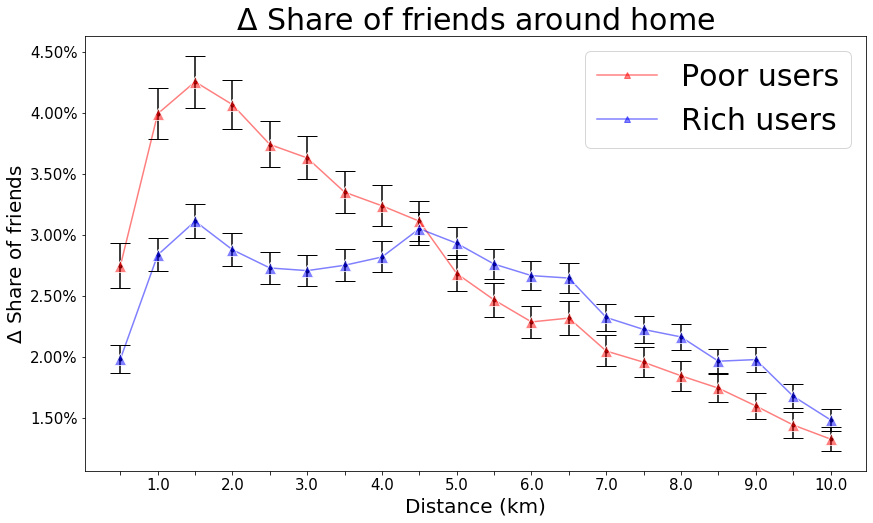

In [218]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(14, 8))

#colors of lines
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]

#lineplot created
ax = sns.lineplot(data = conc2, x = 'distance', y = 'mean', hue = 'type', style = 'type',palette = colorsList, dashes=False, ax = ax, markers=["^", "^"], markersize = 12)

ax.errorbar(data = conc2, x = 'distance', y = 'mean', yerr= [conc2['err_l'], conc2['err_u']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Poor users', 'Rich users'], fontsize = 30)
ax.set(xlabel='Distance (km)', ylabel='$\Delta$ Share of friends')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax.set_title('$\Delta$ Share of friends around home', size = 30)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

## Clustering and support

### Clustering

#### Home

In [150]:
list1 = []

for user in tqdm_notebook(d_table['user_id']):
    time.sleep(.01)
    r = {}
    r['user_id'] = user
    for dist in [1000, 5000, 10000]:
        #get third edges
        lista = list(geo_edgelistn[(geo_edgelistn['user_id1'] == user) & (geo_edgelistn['dh_bin'] <= dist)]['user_id2'])
        if len(lista) < 2:
            r['clusth' + str(dist)] = np.nan
        else:
            a = geo_edgelistn[geo_edgelistn['user_id1'].isin(lista)]
            b = a[a['user_id2'].isin(lista)][['user_id1', 'user_id2']]
            #get df with ego network and below the third edges
            c = pd.concat([geo_edgelistn[geo_edgelistn['user_id1'] == user][['user_id1', 'user_id2']], b], ignore_index = True)

            G = nx.from_pandas_edgelist(c, 'user_id1', 'user_id2')
            r['clusth' + str(dist)] = nx.average_clustering(G)        
    list1.append(r)
clust_table_h = pd.DataFrame(list1)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [203]:
clust_table_h.to_csv("../data/clust_table_h.csv")

In [153]:
clust_table_h = pd.read_csv("../data/clust_table_h.csv", index_col=0)

In [154]:
clust_table_h.head()

,user_id,clusth1000,clusth5000,clusth10000
0,47,0.0,0.229054,0.529399
1,850,NaN,NaN,NaN
2,977,NaN,0.202778,0.202778
3,1027,NaN,NaN,NaN
4,1135,NaN,NaN,NaN


   ## Separate by income level

In [159]:
cluster = pd.merge(clust_table_h, user_geon[['user_id', 'geometry_h']], 'left', on = 'user_id')

In [160]:
cluster = gpd.GeoDataFrame(cluster)
cluster = cluster.set_geometry('geometry_h')

In [161]:
#merge to the tracts all the individuals who live there
cluster = gpd.sjoin(cluster,merged[['inc_group_2', 'geometry']],'left','within')
cluster = cluster.drop(['index_right'], axis = 1)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  


In [162]:
cluster.head()

,user_id,clusth1000,clusth5000,clusth10000,geometry_h,inc_group_2
0,47,0.0,0.229054,0.529399,POINT (-73.95600 40.71700),rich
1,850,NaN,NaN,NaN,POINT (-74.03400 40.98100),rich
2,977,NaN,0.202778,0.202778,POINT (-73.99700 40.72600),rich
3,1027,NaN,NaN,NaN,POINT (-73.79100 41.55800),rich
4,1135,NaN,NaN,NaN,POINT (-74.60000 40.53200),poor


In [163]:
cluster_r = cluster[cluster['inc_group_2'] == 'rich']

In [164]:
cluster_p = cluster[cluster['inc_group_2'] == 'poor']

In [165]:
cluster_p_h = cluster_p[['clusth1000', 'clusth5000', 'clusth10000']]

In [166]:
cluster_r_h = cluster_r[['clusth1000', 'clusth5000', 'clusth10000']]

In [167]:
len(cluster_p_h['clusth1000'].dropna())

1103

### Home

In [168]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["poor"] * 3

for c in list(cluster_p_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(cluster_p_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb8 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb8 = pd.DataFrame(frameb8)

In [169]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["rich"] * 3

for c in list(cluster_r_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(cluster_r_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb9 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb9 = pd.DataFrame(frameb9)

In [170]:
conc3 = pd.concat([resultb8,resultb9])

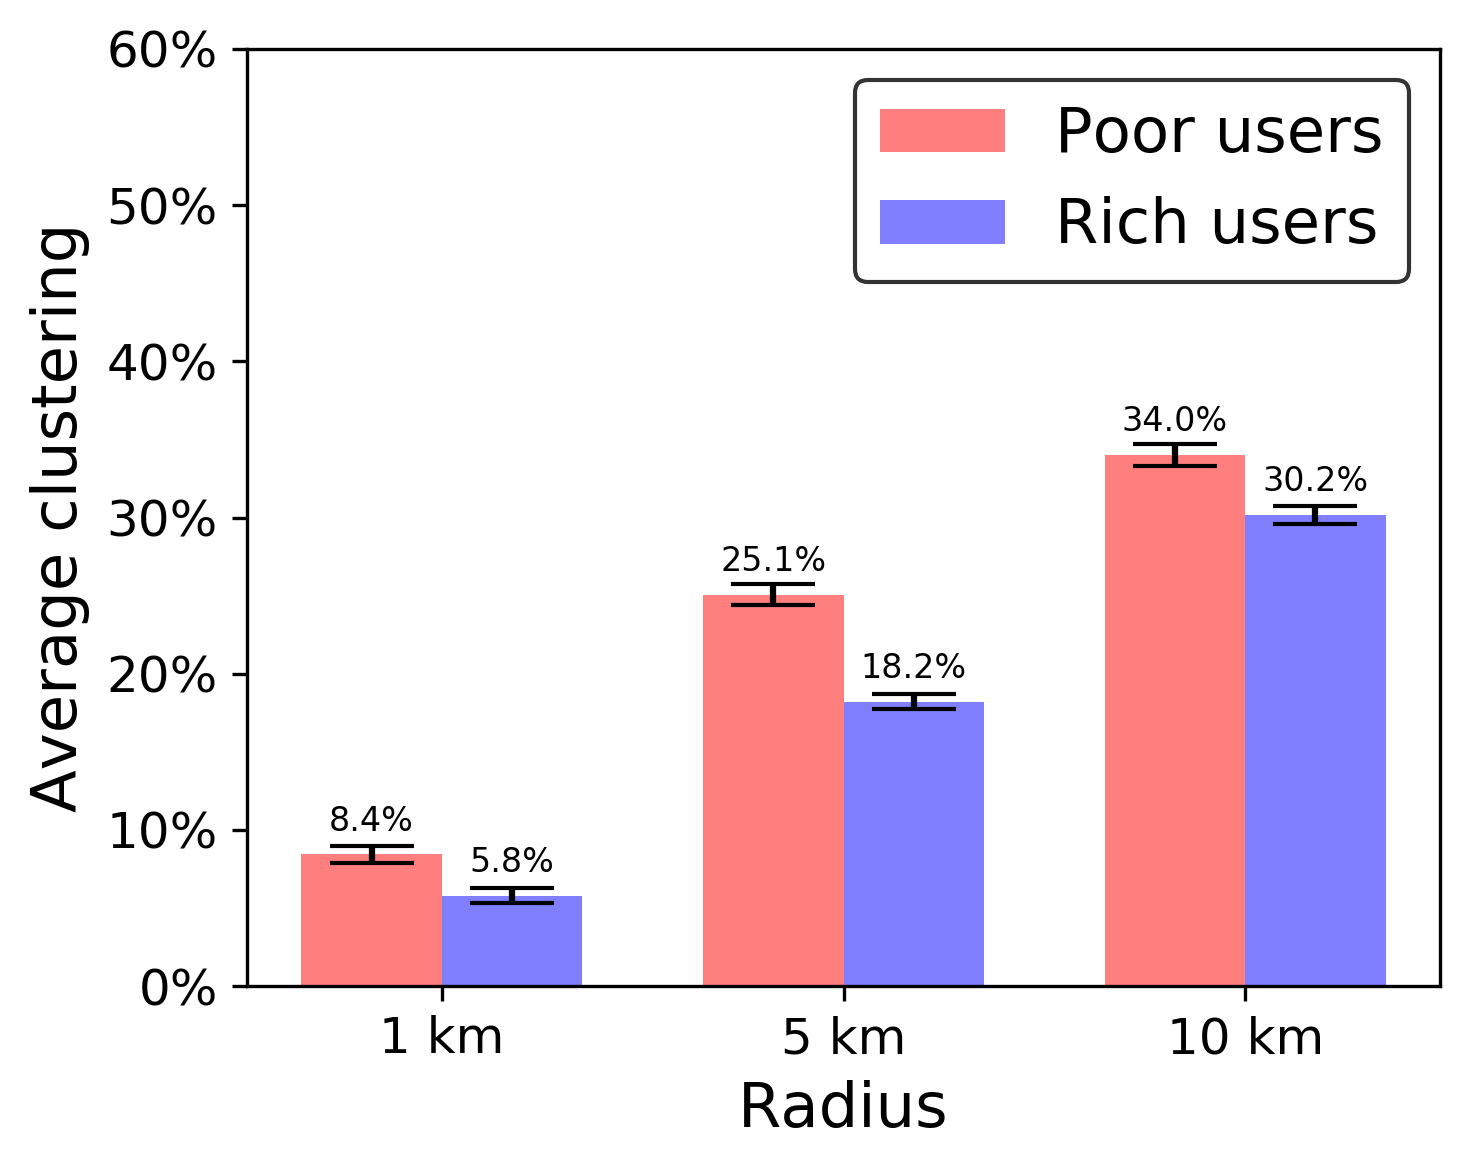

In [193]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=300)

titles = ['1 km', '5 km', '10 km']

#colors of bars
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]
                                                                                                                    
#bar plot created
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, conc3[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [conc3[0:3]['err_l'], conc3[0:3]['err_u']], capsize = 10)
rects2 = ax.bar(X + bar_width, conc3[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [conc3[3:]['err_l'], conc3[3:]['err_u']], capsize = 10) 

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 15, edgecolor = 'black')
ax.set(ylabel='Average clustering')
ax.set(xlabel='Radius')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.6])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 8)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

#plt.savefig('../figures/clustering_home_inc.jpg')

### Support

### Home

In [1037]:
list2 = []

for user in tqdm_notebook(d_table['user_id']):
    r = {}
    r['user_id'] = user
    for dist in [1000, 5000, 10000]:
        #get third edges
        lista2 = list(geo_edgelistn[(geo_edgelistn['user_id1'] == user) & (geo_edgelistn['dh_bin'] <= dist)]['user_id2'])
        if len(lista2) < 2:
            r['suph' + str(dist)] = np.nan
        else:
            a = geo_edgelistn[geo_edgelistn['user_id1'].isin(lista2)]
            b = a[a['user_id2'].isin(lista2)][['user_id1', 'user_id2']]
                       
            r['suph' + str(dist)] = len(b['user_id1'].unique()) / len(lista2) 
    list2.append(r)
sup_table_h = pd.DataFrame(list2)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [1038]:
sup_table_h.to_csv("../data/sup_table_h.csv")

In [172]:
sup_table_h = pd.read_csv("../data/sup_table_h.csv", index_col=0)

In [174]:
sup_table_h.head()

,user_id,suph1000,suph5000,suph10000
0,47,0.0,0.75,0.90566
1,850,NaN,NaN,NaN
2,977,NaN,1.00,1.00000
3,1027,NaN,NaN,NaN
4,1135,NaN,NaN,NaN


In [1045]:
sup_table = sup_table_h.merge(sup_table_w, 'left', on = 'user_id')
sup_table2 = sup_table.iloc[:,1:]
sup_table2.head()

,suph1000,suph5000,suph10000,supw1000,supw5000,supw10000
0,0.0,0.75,0.90566,0.0,0.733333,0.884615
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.00,1.00000,NaN,1.000000,1.000000
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.5,0.700000,0.714286


In [178]:
support = pd.merge(sup_table_h, user_geon[['user_id', 'geometry_h']], 'left', on = 'user_id')
support = gpd.GeoDataFrame(support)
support = support.set_geometry('geometry_h')

In [179]:
#merge to the tracts all the individuals who live there
support = gpd.sjoin(support,merged[['inc_group_2', 'geometry']],'left','within')
support = support.drop(['index_right'], axis = 1)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  


In [180]:
support.head()

,user_id,suph1000,suph5000,suph10000,geometry_h,inc_group_2
0,47,0.0,0.75,0.90566,POINT (-73.95600 40.71700),rich
1,850,NaN,NaN,NaN,POINT (-74.03400 40.98100),rich
2,977,NaN,1.00,1.00000,POINT (-73.99700 40.72600),rich
3,1027,NaN,NaN,NaN,POINT (-73.79100 41.55800),rich
4,1135,NaN,NaN,NaN,POINT (-74.60000 40.53200),poor


In [181]:
support_r = support[support['inc_group_2'] == 'rich']

In [182]:
support_p = support[support['inc_group_2'] == 'poor']

In [183]:
support_p_h = support_p[['suph1000', 'suph5000', 'suph10000']]

In [184]:
support_r_h = support_r[['suph1000', 'suph5000', 'suph10000']]

### Home

In [185]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["poor"] * 3

for c in list(support_p_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(support_p_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb12 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb12 = pd.DataFrame(frameb12)

In [186]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["rich"] * 3

for c in list(support_r_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(support_r_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb13 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb13 = pd.DataFrame(frameb13)

In [187]:
conc5 = pd.concat([resultb12,resultb13])

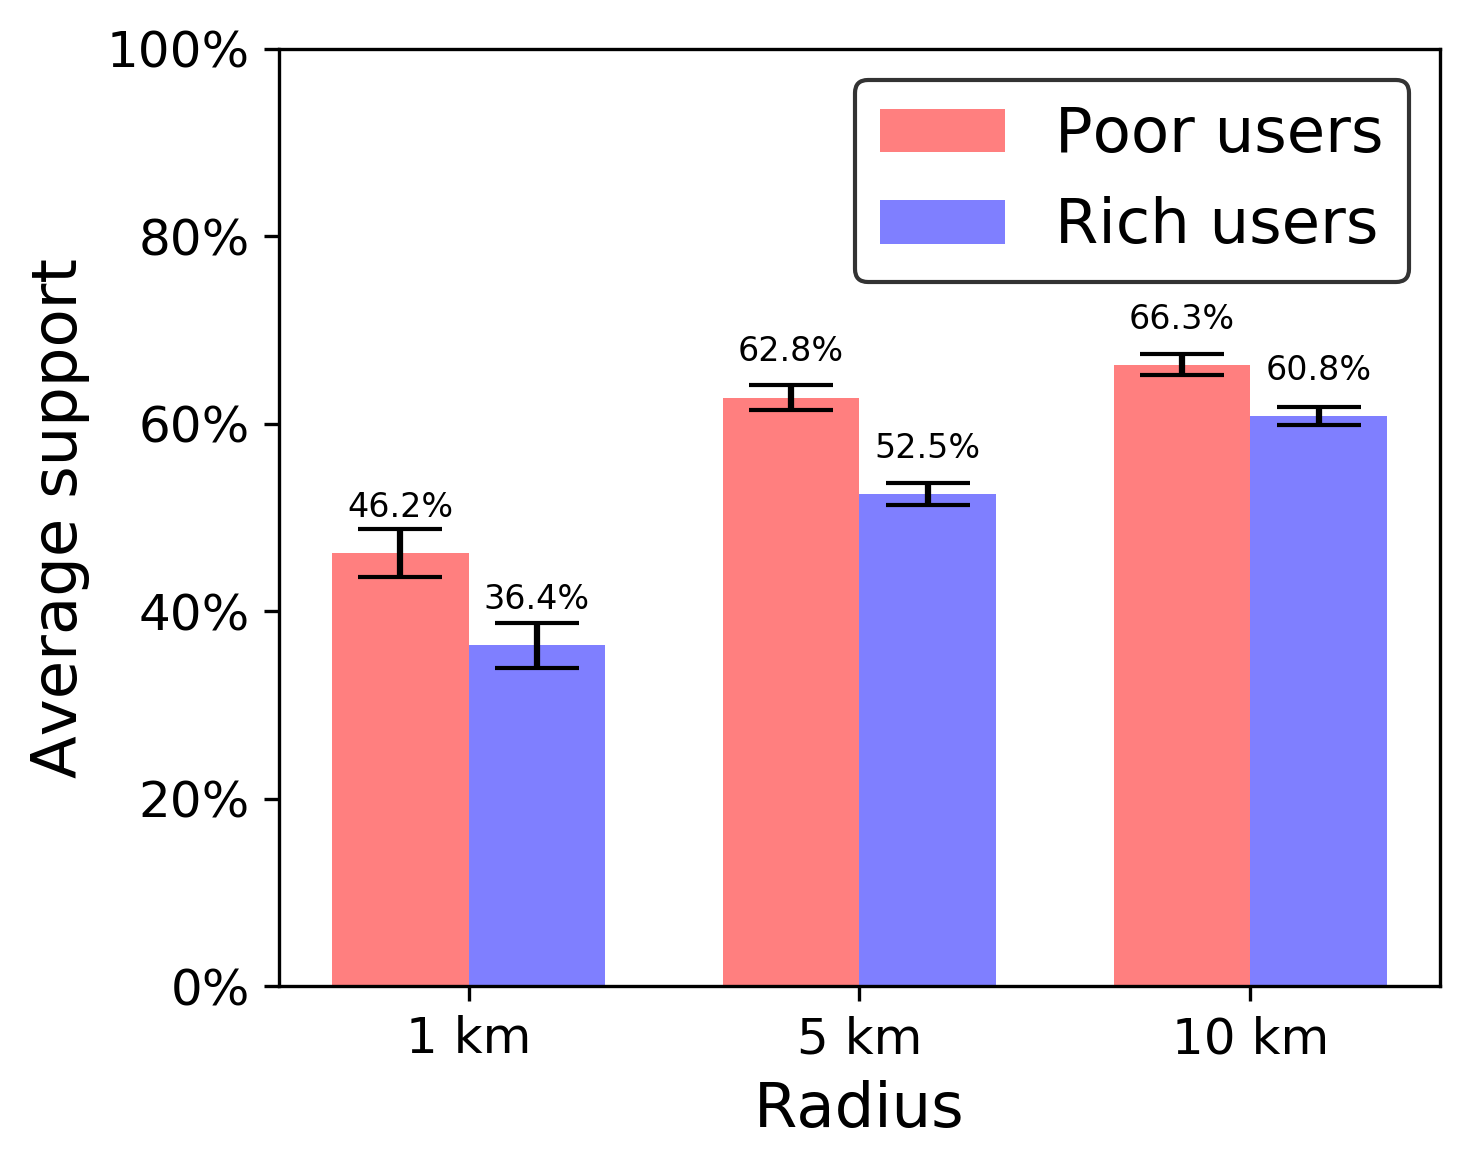

In [192]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=300)

titles = ['1 km', '5 km', '10 km']

#colors of bars
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]
                                                                                                                    
#bar plot created
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, conc5[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [conc5[0:3]['err_l'], conc5[0:3]['err_u']], capsize = 10)
rects2 = ax.bar(X + bar_width, conc5[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [conc5[3:]['err_l'], conc5[3:]['err_u']], capsize = 10) 

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 15, edgecolor = 'black')
ax.set(ylabel='Average support')
ax.set(xlabel='Radius')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 1])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 7),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 8)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

#plt.savefig('../figures/support_home_inc.jpg')